<h1>Parking places</h1>
<h2>Exploration</h2>
<p>
    <ol>
        <li>Get a feeling of the data</li>
        <li>Cluster (just example)</li>
        <li>Group per parking_place per day (count # transactions)</li>
        <li>Select some data (garage_id, time window)</li>
        <li>Calculate rolling mean</li>
        <li>Show graph data</li>
   <li>Later ...see if we can classify on date, maybe other features and say something about how many visitors</li>
        </ol>
       
</p>


In [119]:
%matplotlib inline
import pandas as pd
import numpy as np

<h2>Load the data</h2>

In [3]:
path=''
parking_transactions=pd.read_csv(path+'parkeerdata/leeuwarden_garage_parking_transactions.csv',sep=";")

In [4]:
parking_locations=pd.read_csv(path+'parkeerdata/leeuwarden_garage_parking_garage_gps.csv',sep=";",decimal=",")

In [110]:
automaten_locations = pd.read_excel(path + 'parkeerdata/parkeerautomaten_gps.xlsx', sep = ";", decimal= ",")

In [111]:
print("parking_transactions",parking_transactions.shape)
print("parking_locations",parking_locations.shape)
print("automaten_locations", sensor_locations.shape)

parking_transactions (3380160, 11)
parking_locations (5, 7)
automaten_locations (9, 3)


In [6]:
parking_transactions.head()

,garage_id,card_type_id,transaction_id,start_parking_dt,end_parking_dt,pay_parking_dt,entry_station_cid,pay_station_cid,exit_station_cid
0,36,220,2912536,1-1-2016 00:14,1-1-2016 06:17,1-1-2016 06:14,989.0,998.0,992.0
1,36,220,2912538,1-1-2016 00:27,1-1-2016 05:11,1-1-2016 05:09,989.0,998.0,992.0
2,36,220,2912537,1-1-2016 00:27,1-1-2016 05:56,1-1-2016 05:52,988.0,998.0,993.0
3,36,220,2912539,1-1-2016 00:28,1-1-2016 08:14,1-1-2016 08:06,989.0,998.0,992.0
4,36,220,2912540,1-1-2016 00:34,1-1-2016 04:09,1-1-2016 04:03,989.0,998.0,992.0


In [7]:
parking_locations.head()

,garage_id,garage_nm,capacity_value,latitude,longitude
0,39,Oldehove,525,53.203227,5.789788
1,40,Oosterstraat,250,53.201402,5.801438
2,36,Zaailand,720,53.199224,5.795601
3,37,Klanderij,625,53.197996,5.798296
4,38,Hoeksterend,390,53.205792,5.802553


In [112]:
automaten_locations.head(7)

,Nr.,Locatie,Zone,Tarief,Max parkeerduur,latitude,longitude
1,8901,Willemskade achter justitie,A,2.8,1 uur,53.198622,5.794032
2,8902,Willemskade NZ t/o ABN ARMO bank,A,2.8,1 uur,53.198777,5.792407
3,8903,Zuiderstraat,A,2.8,1 uur,53.198700,5.795136
4,8904,reserve,A,2.8,1 uur,NaN,NaN
5,8905,Beursplein,A,2.8,1 uur,53.198795,5.795872


Soms is de locatie niet bekend.

<h2>Plot the latitude and longitude of the parking locations</h2>

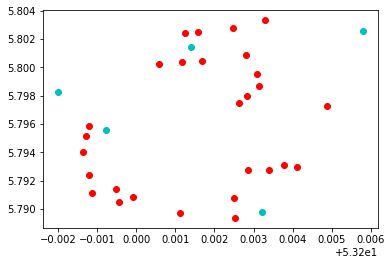

In [113]:
import matplotlib.pyplot as plt
plt.plot(parking_locations.latitude, parking_locations.longitude,'co')
plt.plot(automaten_locations.latitude, automaten_locations.longitude, 'ro')

In [39]:
parking_locations.garage_nm

0        Oldehove
1    Oosterstraat
2        Zaailand
3       Klanderij
4     Hoeksterend
Name: garage_nm, dtype: object

In [124]:
import folium #note: will not run in explorer
folium_map = folium.Map(location=[np.mean(parking_locations.latitude[:]), np.mean(parking_locations.longitude[:])],
                        zoom_start=14, width = 500, height = 300, control_scale = True)
#folium.TileLayer('openstreetmap').add_to(folium_map)
#folium.LayerControl().add_to(folium_map)
for i in range(len(parking_locations)):
    folium.Marker([parking_locations.latitude[i], parking_locations.longitude[i]],
                  popup = parking_locations.garage_nm[i], icon=folium.Icon(icon='car', prefix='fa')).add_to(folium_map)

#er zitten wat lege waarden tussen, dus die halen we er uit
automaten_locations_nonNA = automaten_locations.dropna()
automaten_locations_nonNA = automaten_locations_nonNA.reset_index(drop=True)
for i in range(len(automaten_locations_nonNA)):
    folium.RegularPolygonMarker([automaten_locations_nonNA.latitude[i], automaten_locations_nonNA.longitude[i]],
                                fill_color = 'black', number_of_sides = 20, radius = 5).add_to(folium_map)
folium_map


<h2>K-Means Clustering</h2>
<p>
    <ol>
<li>Perform K-means clustering on the dataset using the *KMeans* function from sklearn.cluster. </li>
<li>Perform a prediction using *predict()* on the data set. </li>
<li>Show the results by coloring each dot in the scatterplot  </li>
<li>We would like to create two groups (why? just for demonstrating now) so the number of clusters the algorithm is two.</li>
    </ol>
</p>

In [91]:
parking_locations[['latitude', 'longitude']] = parking_locations[['latitude', 'longitude']].astype(float)
parking_locations

,garage_id,garage_nm,capacity_value,latitude,longitude
0,39,Oldehove,525,53.203227,5.789788
1,40,Oosterstraat,250,53.201402,5.801438
2,36,Zaailand,720,53.199224,5.795601
3,37,Klanderij,625,53.197996,5.798296
4,38,Hoeksterend,390,53.205792,5.802553


array([1, 0, 1, 1, 0])

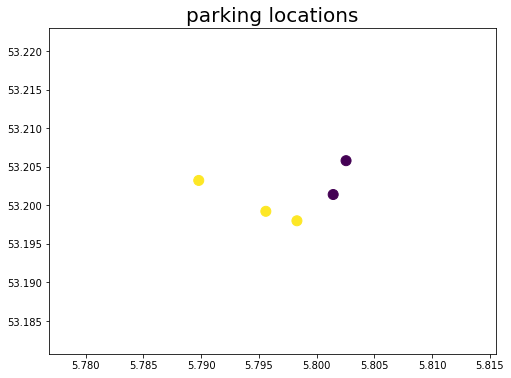

In [92]:
from sklearn.cluster import KMeans
X =parking_locations[['latitude','longitude']] 
k_means=KMeans(n_clusters=2,random_state=0)
k_means.fit(X)
cluster_values=k_means.predict(X)
fig = plt.figure(figsize=(8, 6)) 
plt.title("parking locations",size=20)
plt.scatter(X.longitude,X.latitude,c=cluster_values,s=100)

cluster_values

In [72]:
fmap = folium.Map(location=[np.mean(parking_locations.latitude[:]), np.mean(parking_locations.longitude[:])],
                        zoom_start=14, width = 500, height = 300, control_scale = True)
for i in range(len(parking_locations)):
    folium.Marker([parking_locations.latitude[i], parking_locations.longitude[i]],
                  popup = parking_locations.garage_nm[i], icon=folium.Icon(prefix = 'fa', icon ='car', color = cluster_values[i]*'orange')).add_to(fmap)
#folium.TileLayer('stamentoner').add_to(folium_map)
fmap

<h2>Add the column with the cluster number to the dataset and save it to csv</h2>

In [93]:
parking_locations['cluster']=cluster_values
parking_locations.head()

,garage_id,garage_nm,capacity_value,latitude,longitude,cluster
0,39,Oldehove,525,53.203227,5.789788,1
1,40,Oosterstraat,250,53.201402,5.801438,0
2,36,Zaailand,720,53.199224,5.795601,1
3,37,Klanderij,625,53.197996,5.798296,1
4,38,Hoeksterend,390,53.205792,5.802553,0


In [94]:
parking_locations.to_csv("../data/out-clusters.csv",sep=";")

#### Extra information about the groups

In [95]:
k_means.labels_

array([1, 0, 1, 1, 0])

In [96]:
parking_locations['labels'] = k_means.labels_
# df_labels=pd.DataFrame({'labels': kmeans.labels_})
label_groups = parking_locations.groupby('labels')

for name, group in label_groups:
    print(name) 
    print(group.describe())

0
       garage_id  capacity_value   latitude  longitude  cluster  labels
count   2.000000        2.000000   2.000000   2.000000      2.0     2.0
mean   39.000000      320.000000  53.203597   5.801996      0.0     0.0
std     1.414214       98.994949   0.003104   0.000789      0.0     0.0
min    38.000000      250.000000  53.201402   5.801438      0.0     0.0
25%    38.500000      285.000000  53.202499   5.801717      0.0     0.0
50%    39.000000      320.000000  53.203597   5.801996      0.0     0.0
75%    39.500000      355.000000  53.204694   5.802275      0.0     0.0
max    40.000000      390.000000  53.205792   5.802553      0.0     0.0
1
       garage_id  capacity_value   latitude  longitude  cluster  labels
count   3.000000        3.000000   3.000000   3.000000      3.0     3.0
mean   37.333333      623.333333  53.200149   5.794562      1.0     1.0
std     1.527525       97.510683   0.002736   0.004348      0.0     0.0
min    36.000000      525.000000  53.197996   5.789788      

<h2>Group the visits per parking_place per day</h2>


In [99]:
parking_transactions['visit_datetime'] = pd.to_datetime(parking_transactions['start_parking_dt'], format='%d-%m-%Y %H:%M')
#'1-1-2016 00:14' 
parking_transactions['visit_date'] = parking_transactions['visit_datetime'].dt.date
parking_transactions.head()

,garage_id,card_type_id,transaction_id,start_parking_dt,end_parking_dt,pay_parking_dt,entry_station_cid,pay_station_cid,exit_station_cid,visit_datetime,visit_date
0,36,220,2912536,1-1-2016 00:14,1-1-2016 06:17,1-1-2016 06:14,989.0,998.0,992.0,2016-01-01 00:14:00,2016-01-01
1,36,220,2912538,1-1-2016 00:27,1-1-2016 05:11,1-1-2016 05:09,989.0,998.0,992.0,2016-01-01 00:27:00,2016-01-01
2,36,220,2912537,1-1-2016 00:27,1-1-2016 05:56,1-1-2016 05:52,988.0,998.0,993.0,2016-01-01 00:27:00,2016-01-01
3,36,220,2912539,1-1-2016 00:28,1-1-2016 08:14,1-1-2016 08:06,989.0,998.0,992.0,2016-01-01 00:28:00,2016-01-01
4,36,220,2912540,1-1-2016 00:34,1-1-2016 04:09,1-1-2016 04:03,989.0,998.0,992.0,2016-01-01 00:34:00,2016-01-01


In [101]:
parking_transactions.tail()

,garage_id,card_type_id,transaction_id,start_parking_dt,end_parking_dt,pay_parking_dt,entry_station_cid,pay_station_cid,exit_station_cid,visit_datetime,visit_date
3380155,36,220,4536604,31-3-2018 23:50,1-4-2018 05:48,1-4-2018 05:46,989.0,998.0,992.0,2018-03-31 23:50:00,2018-03-31
3380156,36,220,4536605,31-3-2018 23:51,1-4-2018 03:54,1-4-2018 03:54,988.0,NaN,992.0,2018-03-31 23:51:00,2018-03-31
3380157,36,220,4536606,31-3-2018 23:51,1-4-2018 03:20,1-4-2018 03:18,989.0,998.0,993.0,2018-03-31 23:51:00,2018-03-31
3380158,36,220,4536607,31-3-2018 23:55,1-4-2018 16:33,1-4-2018 16:29,989.0,1009.0,992.0,2018-03-31 23:55:00,2018-03-31
3380159,36,221,4536608,31-3-2018 23:59,2-4-2018 13:06,NaN,988.0,NaN,993.0,2018-03-31 23:59:00,2018-03-31


In [103]:
visitors_per_day = parking_transactions.groupby(['garage_id','visit_date'],as_index=False)['transaction_id'].count().rename(columns=
                                                {'transaction_id':'count_transactions'})
visitors_per_day.head()

,garage_id,visit_date,count_transactions
0,36,2016-01-01,328
1,36,2016-01-02,2740
2,36,2016-01-03,1201
3,36,2016-01-04,1263
4,36,2016-01-05,456


<h2>Make a selection of the data and show this</p></h2>
* Pick a garage_id, and a time_window

In [105]:
from_datetime="2016-01-01 00:00:00"
to_datetime="2016-03-01 00:00:00"
garage_id=36
# create a date_time column, and filter using a 'mask' 
visitors_per_day['visit_datetime'] = pd.to_datetime(visitors_per_day['visit_date'])
mask = (visitors_per_day['visit_datetime']>=from_datetime) & (visitors_per_day['visit_datetime'] <= 
                                                              to_datetime) & (visitors_per_day['garage_id']==garage_id)
# not necessary, but one is allowed to remove that superfluous column here
#visitors_per_day=visitors_per_day.drop(['visit_datetime'], axis=1)
selected= visitors_per_day.loc[mask]
print("from", from_datetime,"to",to_datetime,"aantal:",len(selected))
selected.head(5)


from 2016-01-01 00:00:00 to 2016-03-01 00:00:00 aantal: 61


,garage_id,visit_date,count_transactions,visit_datetime
0,36,2016-01-01,328,2016-01-01
1,36,2016-01-02,2740,2016-01-02
2,36,2016-01-03,1201,2016-01-03
3,36,2016-01-04,1263,2016-01-04
4,36,2016-01-05,456,2016-01-05


<h2>Calculate a rolling mean of visitors</h2>
 Compute the rolling mean (see https://stackoverflow.com/questions/15771472/pandas-rolling-mean-by-time-interval on how to implement a rolling mean in pandas). Choose a proper window size. 


In [109]:
with_rolling_mean=selected.copy()
with_rolling_mean['RollingMean']=with_rolling_mean['count_transactions'].rolling(window=7).mean()
with_rolling_mean.head(9)


,garage_id,visit_date,count_transactions,visit_datetime,RollingMean
0,36,2016-01-01,328,2016-01-01,NaN
1,36,2016-01-02,2740,2016-01-02,NaN
2,36,2016-01-03,1201,2016-01-03,NaN
3,36,2016-01-04,1263,2016-01-04,NaN
4,36,2016-01-05,456,2016-01-05,NaN
5,36,2016-01-06,521,2016-01-06,NaN
6,36,2016-01-07,1214,2016-01-07,1103.285714
7,36,2016-01-08,2768,2016-01-08,1451.857143
8,36,2016-01-09,2740,2016-01-09,1451.857143


Show the number of visits in a graph
Plot the total amount of visitors on a given day in a plot. Add the rolling mean to the same plot. 

Text(0.5,1,'# visits per day')

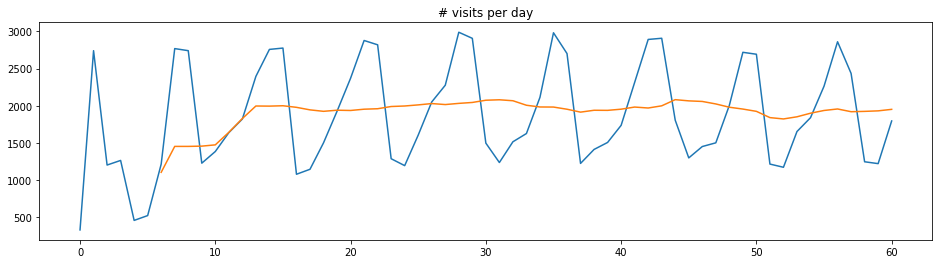

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16, 4)) 
plt.plot(with_rolling_mean['count_transactions'])
plt.plot(with_rolling_mean['RollingMean'])
plt.title("# visits per day")

## Analyse op transaction ID

Hier laten we zien dat er geen informatie uit transaction_id te halen valt.

In [125]:
# we maken 1 dataset met alle transacties uit abonnementen (card_type_id = 221), en tellen de unieke transaction_id's
parking_abbo40 = parking_transactions.loc[np.logical_and(parking_transactions.card_type_id == 221,parking_transactions.garage_id == 40)]
unique_abbo40 = set()
for ID in parking_abbo40.transaction_id:
    unique_abbo40.add(ID)
print("Aantal unieke transaction_id's: ", len(unique_abbo40))
print("Aantal regels in parking_abbo40: ", len(parking_abbo40))

Aantal unieke transaction_id's:  91497
Aantal regels in parking_abbo40:  91497


Deze waarden zijn hetzelfde. We doen nu hetzelfde bij de losse parkeerkaarten:

In [126]:
parking_los40 = parking_transactions.loc[np.logical_and(parking_transactions.card_type_id == 220,parking_transactions.garage_id == 40)]
unique_los40 = set()
for ID in parking_los40.transaction_id:
    unique_los40.add(ID)
print("Aantal unieke transaction_id's: ", len(unique_los40))
print("Aantal regels in parking_los40: ", len(parking_los40))

Aantal unieke transaction_id's:  49143
Aantal regels in parking_los40:  49143


We nemen aan dat dit voor alle parkeergarages geldt. In de volledige dataset zitten wel transaction_id's die vaker voorkomen, maar ik denk dat die id's niet uit dezelfde parkeergarage komen.

## Verschillen tussen card_type_id = {220,221} (kort parkeren en abonnement)

In [127]:
visitors_per_day2 = parking_transactions.groupby(['garage_id','visit_date', 'card_type_id'],as_index=False)['transaction_id'].count().rename(columns={'transaction_id':'count_transactions'})
visitors_per_day2.head(10)

,garage_id,visit_date,card_type_id,count_transactions
0,36,2016-01-01,220,299
1,36,2016-01-01,221,29
2,36,2016-01-02,220,2686
3,36,2016-01-02,221,54
4,36,2016-01-03,220,1143
5,36,2016-01-03,221,58
6,36,2016-01-04,220,1162
7,36,2016-01-04,221,101
8,36,2016-01-05,220,377
9,36,2016-01-05,221,79


In [138]:
from_datetime="2016-01-01 00:00:00"
to_datetime="2016-03-01 00:00:00"
garage_id=36
card_type_id = 220

visitors_per_day2['visit_datetime'] = pd.to_datetime(visitors_per_day2['visit_date'])
mask = (visitors_per_day2['visit_datetime']>=from_datetime) & (visitors_per_day2['visit_datetime'] < 
       to_datetime) & (visitors_per_day2['garage_id']==garage_id)
selected220= visitors_per_day2.loc[mask & (visitors_per_day2['card_type_id'] == card_type_id)]
selected221= visitors_per_day2.loc[mask & (visitors_per_day2['card_type_id'] == 221)]
#fix the indices
selected220 = selected220.reset_index()
selected221 = selected221.reset_index()

print("from", from_datetime,"to",to_datetime,"aantal:",len(selected220))
selected220.head(5)
print("from", from_datetime,"to",to_datetime,"aantal:",len(selected221))
selected221.head(5)

from 2016-01-01 00:00:00 to 2016-03-01 00:00:00 aantal: 60
from 2016-01-01 00:00:00 to 2016-03-01 00:00:00 aantal: 60


,index,garage_id,visit_date,card_type_id,count_transactions,visit_datetime
0,1,36,2016-01-01,221,29,2016-01-01
1,3,36,2016-01-02,221,54,2016-01-02
2,5,36,2016-01-03,221,58,2016-01-03
3,7,36,2016-01-04,221,101,2016-01-04
4,9,36,2016-01-05,221,79,2016-01-05


Voeg dag van de week toe. 1 januari 2016 is een vrijdag.

In [145]:
days = ['Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu']
#days_partial = days[:len(selected220)%7]
#days_partial
selected220['day_of_week'] = ''
for i in range(len(selected220)):
    selected220['day_of_week'][i] = days[i%7]
#np.repeat([days, days_partial], [len(selected220)/7,1], axis = 0)
selected220.head()

C:\Users\verho534\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,garage_id,visit_date,card_type_id,count_transactions,visit_datetime,day_of_week
0,0,36,2016-01-01,220,299,2016-01-01,Fri
1,2,36,2016-01-02,220,2686,2016-01-02,Sat
2,4,36,2016-01-03,220,1143,2016-01-03,Sun
3,6,36,2016-01-04,220,1162,2016-01-04,Mon
4,8,36,2016-01-05,220,377,2016-01-05,Tue


AttributeError: 'Figure' object has no attribute 'set_xticklabels'

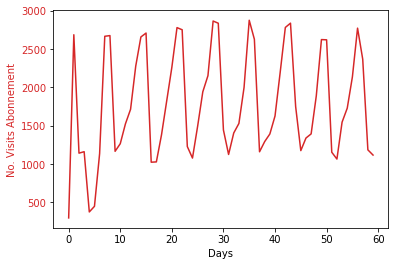

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('No. Visits Abonnement', color=color)
ax1.plot(selected220['count_transactions'],color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.set_xticklabels(selected['days_of_week'], rotation=0)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('No. Visits Kort Parkeren', color=color)  # we already handled the x-label with ax1
ax2.plot(selected221['count_transactions'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Je ziet dat de abonnementshouders 1 piek per week veroorzaken, en de mensen die kort parkeren verhoorzaken 2 pieken per week, waarvan 1 gelijkloopt met de piek van de abonnementshouders. Ik wil graag zien op welke dagen deze pieken zijn.

De dagen kloppen niet want dit is gebaseerd op index. Die staan nu niet goed!
